In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import markers as mkrs
from itertools import product

In [3]:
def create_file_name(kind: str, fn: str, fixed_vls: dict, spread: bool):
    fn += "_" + kind
    translation = {'decoherence': "dec", "p_bell_success": "lde_success"}
    for k, v in fixed_vls.items():
        if k in filename_skip_parameters or v == False:
            continue
        if k in translation:
            k = translation[k]

        fn += "_{}{}".format(k, v if not type(v) == bool else "")

    if cutoff_results:
        fn += "_cutoff"
    if spread:
        fn += "_spread"

    return fn

In [4]:
def get_marker_index(marker_cols, run_dict):
    marker_ind = tuple()
    for value in marker_cols:
        marker_ind += (run_dict[value],)

    return marker_ind

In [5]:
def get_label_name(run_dict):
    value_translation = {"decoherence": "dec", "fixed_lde_attempts": "decoupling"}
    keep_key = ['pg', 'pn', 'pm', 'pm_1']
    name = ""
    for key, value in run_dict.items():
        if value:
            if key in value_translation:
                value = value_translation[key]
            name += "{}{}, ".format(key + "=" if key in keep_key else "", str(value).replace("_swap", ""))

    name = name.strip(", ")

    return name

In [6]:
def keep_rows_to_evaluate(df):
    if cutoff_results:
        df = df[df['cut_off_time'] != np.inf]
    else:
        df = df[df['cut_off_time'] == np.inf]

    for key, values in evaluate_values.items():
        if values:
            df = df[df[key].isin(values)]

    return df

In [7]:
def identify_indices(df: pd.DataFrame):
    no_index_idicators = ['99', 'ghz', 'avg', 'sem', 'spread', 'IIII', 'written', 'cut', 'pulse']
    index_columns = {}
    fixed_values = {}
    for column in df:
        if all([indicator not in column for indicator in no_index_idicators]):
            unique_values = sorted(set(df[column]))
            if len(unique_values) > 1 or column in ['decoherence', 'protocol_name', 'node']:
                index_columns[column] = unique_values
            elif len(unique_values) == 1:
                fixed_values[column] = unique_values[0]

    return index_columns, fixed_values

In [8]:
def plot_style(title=None, xlabel=None, ylabel=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplots_adjust(left=0.08, bottom=0.08, right=.95, top=.95)
    ax.grid(color='w', linestyle='-', linewidth=2)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    for key, arg in kwargs.items():
        func = getattr(ax, f"set_{key}")
        func(arg)
    ax.patch.set_facecolor('0.95')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    return fig, ax

In [9]:
def scatter_plot(y_value, title, xlabel, ylabel, df: pd.DataFrame, marker_cols, index_dict, spread=False,
                 no_dec_small=True):
    colors = {}
    [colors.update({name: color}) for name, color in zip(index_dict['protocol_name'], mcolors.TABLEAU_COLORS)]
    points = list(mkrs.MarkerStyle.filled_markers)
    fig, ax = plot_style(title, xlabel, ylabel)
    i = 0
    protocol_markers = {}
    for index_tuple in product(*index_dict.values()):
        iteration_dict = dict(zip(index_dict.keys(), index_tuple))
        index = tuple(iteration_dict.values())

        if index in df.index:
            protocol = iteration_dict['protocol_name']
            node = iteration_dict['node']
            dec = iteration_dict['decoherence']
            marker_index = get_marker_index(marker_cols, iteration_dict)
            if marker_index not in protocol_markers:
                protocol_markers[marker_index] = i
                i += 1
            color = colors[protocol]
            dataframe_new = df.loc[index, :]
            style = 'none' if node == 'Purified' else 'full'
            error = {'ghz_fidelity': 'ghz', "IIII": "stab"}
            y_err = [[dataframe_new[error[y_value] + '_lspread']], [dataframe_new[error[y_value] + '_rspread']]]
            x_err = [[dataframe_new['dur_lspread']], [dataframe_new['dur_rspread']]]
            ax.errorbar(dataframe_new['avg_duration'],
                        dataframe_new[y_value],
                        yerr=None if not spread or not dec else y_err,
                        xerr=None if not spread or not dec else x_err,
                        marker=points[protocol_markers[marker_index]],
                        color=color,
                        ms=18 if dec or not no_dec_small else 8,
                        capsize=12,
                        label=get_label_name(iteration_dict),
                        fillstyle=style,
                        linestyle='')

    return fig, ax

In [10]:
def main(spread, save, file_name, file_path, no_dec_small):
    dataframe = pd.read_csv(file_name, sep=';', float_precision='round_trip')
    dataframe = keep_rows_to_evaluate(dataframe)
    index_dict, fixed_values = identify_indices(dataframe)
    marker_index_cols = set(index_dict).difference(['node', 'protocol_name'])
    dataframe = dataframe.set_index(list(index_dict.keys()))

    fig, ax = scatter_plot("ghz_fidelity", "GHZ fidelity vs. duration", "Duration (s)",
                           "Fidelity", dataframe, marker_index_cols, index_dict, spread=spread,
                           no_dec_small=no_dec_small)
    fig2, ax2 = scatter_plot("IIII", "Stabilizer fidelity vs. duration", "Duration (s)", "Fidelity",
                             dataframe, marker_index_cols, index_dict, spread=spread, no_dec_small=no_dec_small)

    ax2.legend(prop={'size': 10})
    ax.legend(prop={'size': 10})
    plt.show()

    if save:
        file_path_stab = create_file_name('stab', file_path, fixed_values, spread)
        file_path_ghz = create_file_name('ghz', file_path, fixed_values, spread)
        fig.savefig(file_path_ghz + ".pdf", transparent=False, format="pdf", bbox_inches="tight")
        fig2.savefig(file_path_stab + ".pdf", transparent=False, format="pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


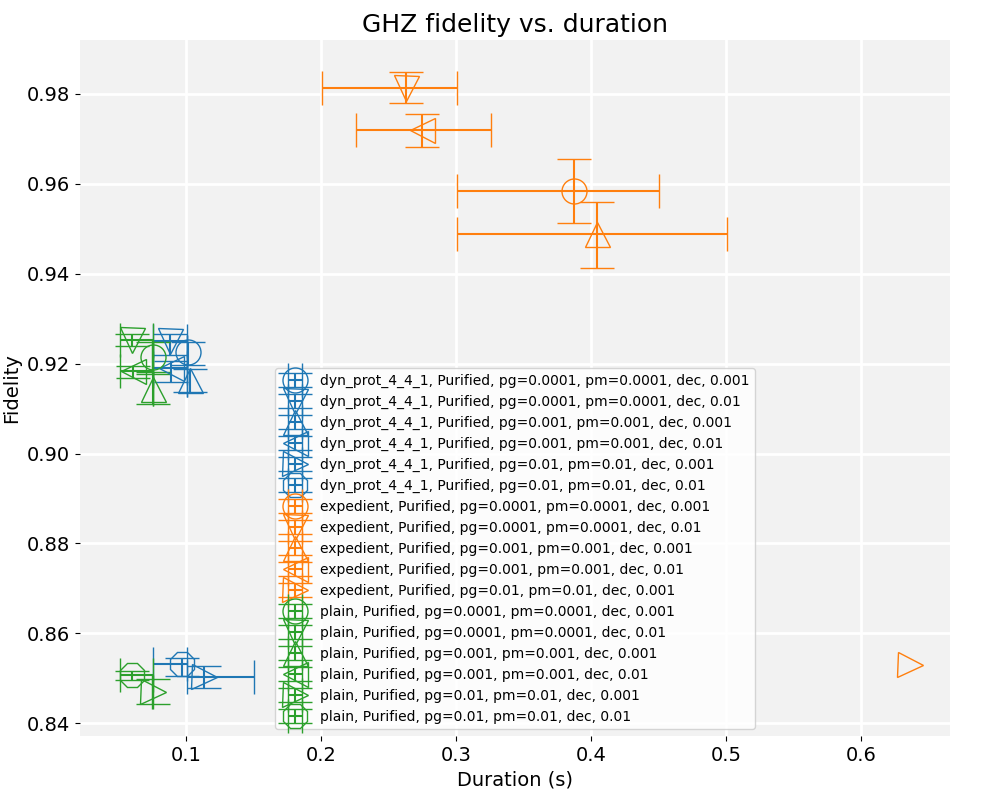

<IPython.core.display.Javascript object>


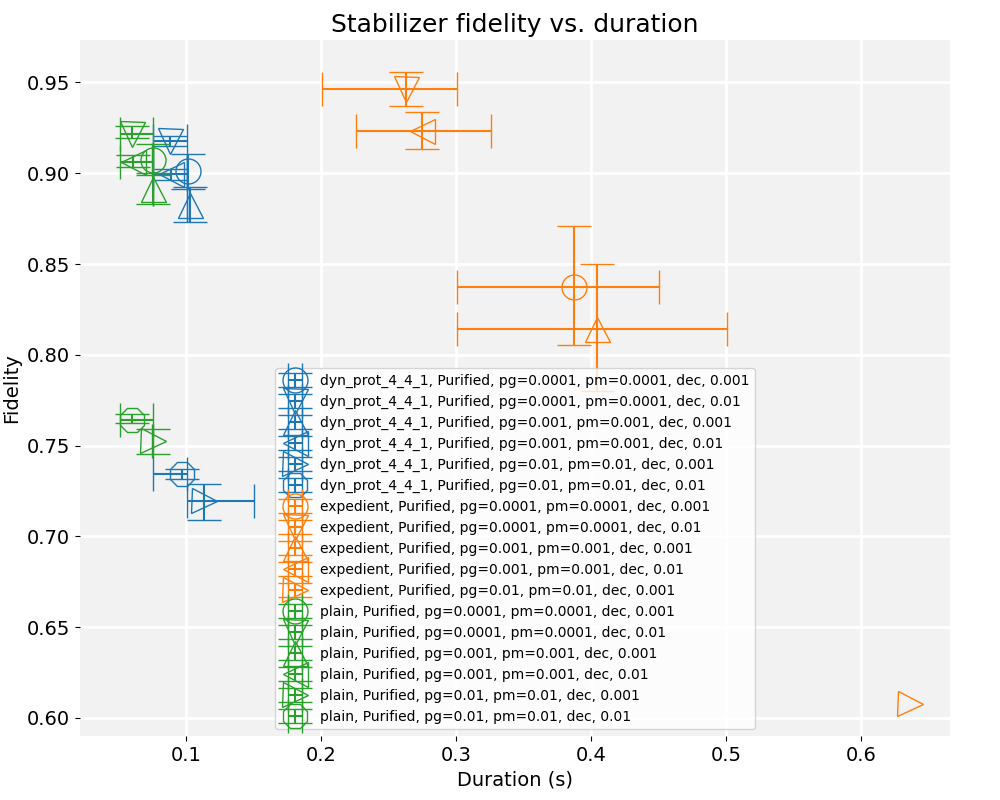

In [11]:
# General booleans
spread = True           # Shows the 68.2% spread error bars
save = False             # Saves the figures to the given filepath
no_dec_small = True     # Plots the data points without decoherence smaller

# Input and output file parameters
file_name = 'circuit_data_NV.csv'
filename_skip_parameters = ['basis_transformation_noise', 'network_noise_type', 'probabilistic',
                            'no_single_qubit_error']
file_path = 'plot_data'

# Filter on the data of the input file
cutoff_results = False
evaluate_values = {'decoherence':           [True],
                   'fixed_lde_attempts':    [2000],
                   'node':                  [],
                   'p_bell_success':        [0.01, 0.001],
                   'pg':                    [0.01, 0.001, 0.0001],
                   'pm':                    [],
                   'pm_1':                  [],
                   'protocol_name':         [],
                   }

main(spread, save, file_name, file_path, no_dec_small)